In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

# Project 5: Modeling the Electrostatic Field of an Ion Trap

## Task Description

The goal of this project is to numerically determine the electrostatic potential inside an ion trap formed by a system of cylindrical electrodes with applied voltages. Assuming there are no charges within the region, the problem reduces to solving Laplace’s equation for the electrostatic potential.

Due to the cylindrical symmetry of the system, the problem can be simplified to two dimensions (radial coordinate ρ and axial coordinate z). The Laplace equation will be discretized using the finite difference method on a grid, and the solution will be found iteratively using the relaxation method.

The main tasks are:
- Implement the relaxation method to solve Laplace’s equation numerically,
- Solve the equation for given grid parameters and boundary conditions,
- Visualize the results by plotting 2D and 3D maps of the potential distribution,
- Plot cross-sections of the potential along the symmetry axis and at a fixed radial distance, including fitting with parabolic curves,
- Analyze and discuss the obtained solution.

This project involves understanding boundary conditions, numerical discretization, and iterative methods for partial differential equations in the context of electrostatic ion traps.


In [2]:
class IonTrap:
    """
    Simulates the electrostatic potential distribution inside an ion trap
    using finite difference relaxation on a cylindrical grid.

    Parameters:
    -----------
    n : int
        Number of grid points along the radial direction (ρ).
    m : int
        Number of grid points along the axial direction (z).
    j1 : int
        Index dividing the bottom electrode into segments with different potentials (start of grounded segment).
    j2 : int
        Index dividing the bottom electrode into segments with different potentials (end of grounded segment).
    delta_z : float
        Grid spacing along the axial (z) direction.
    delta_ro : float
        Grid spacing along the radial (ρ) direction.
    ITMAX : int
        Maximum number of iterations for the relaxation solver.
    V0 : float
        Applied potential on the end electrodes.

    Methods:
    --------
    solve()
        Runs the relaxation method to compute the potential distribution.
    """
    
    def __init__(self, n=30, m=150, j1=60, j2=90,
                 delta_z=0.1, delta_ro=0.1,
                 ITMAX=5000, V0=10):
        self.__n = n
        self.__m = m
        self.__j1 = j1
        self.__j2 = j2
        self.__delta_z = delta_z
        self.__delta_ro = delta_ro
        self.__ITMAX = ITMAX
        self.__V0 = V0

        # initialize grid including boundaries
        self.grid = np.zeros((n+1, m+1))
        # apply Dirichlet BCs to the end electrode (i = n)
        self.grid[n, 0:j1+1]   = V0      # area 1
        self.grid[n, j1+1:j2+1] = 0      # area 2
        self.grid[n, j2+1:m+1] = V0      # area 3

    def _update_grid(self):
        n, m = self.n, self.m
        dz, dro = self.delta_z, self.delta_ro
        j1, j2 = self.j1, self.j2
        V0 = self.V0

        # coefficient A from eq. (10)
        A = 1.0 / (2.0/dro**2 + 2.0/dz**2)

        # keep a copy of the old grid for updates
        V_old = self.grid.copy()
        V_new = V_old.copy()

        # interior relaxation loop (i=1..n-1, j=1..m-1)
        for i in range(1, n):
            rho_i = i * dro
            for j in range(1, m):
                p1 = (V_old[i+1, j] + V_old[i-1, j]) / (dro**2)
                p2 = (V_old[i+1, j] - V_old[i-1, j]) / (2 * dro * rho_i)
                p3 = (V_old[i, j+1] + V_old[i, j-1]) / (dz**2)
                V_new[i, j] = A * (p1 + p2 + p3)

        # re-apply boundary conditions to V_new

        # Dirichlet on i = n (outer cylinder segments)
        V_new[n, 0:j1+1]    = V0
        V_new[n, j1+1:j2+1] = 0
        V_new[n, j2+1:m+1]  = V0

        # Neumann at z = m (top), ∂V/∂z=0 → V[i, m] = V[i, m-1]
        V_new[1:n, m] = V_new[1:n, m-1]

        # Neumann at z = 0 (bottom), ∂V/∂z=0 → V[i, 0] = V[i, 1]
        V_new[1:n, 0] = V_new[1:n, 1]

        # Neumann at ρ = 0 (axis), ∂V/∂ρ=0 → V[0, j] = V[1, j]
        V_new[0, 1:m] = V_new[1, 1:m]

        V_new[0, 0] = V_new[1, 1]
        V_new[0, m] = V_new[1, m-1]


        # swap in the updated grid
        self.grid = V_new

    def solve(self):
        for _ in range(self.ITMAX):
            self._update_grid()

    @property
    def n(self): return self.__n
    @property
    def m(self): return self.__m
    @property
    def j1(self): return self.__j1
    @property
    def j2(self): return self.__j2
    @property
    def delta_z(self): return self.__delta_z
    @property
    def delta_ro(self): return self.__delta_ro
    @property
    def ITMAX(self): return self.__ITMAX
    @property
    def V0(self): return self.__V0


In [3]:
A = IonTrap()
A.solve()

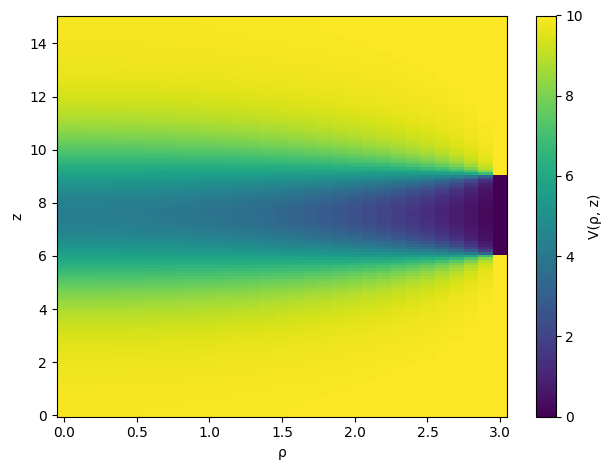

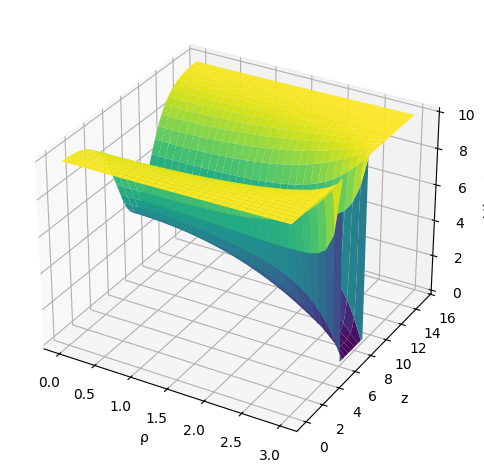

In [15]:
trap = A

# Create meshgrid
rho = np.arange(0, trap.n + 1) * trap.delta_ro
z = np.arange(0, trap.m + 1) * trap.delta_z
RR, ZZ = np.meshgrid(rho, z, indexing='ij')

V = trap.grid
vmin, vmax = V.min(), V.max()
cmap = 'viridis'

# 2D color map
plt.figure()
plt.pcolormesh(RR, ZZ, V, shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)
plt.colorbar(label='V(ρ, z)')
plt.xlabel('ρ')
plt.ylabel('z')
plt.tight_layout()
plt.show()

# 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(RR, ZZ, V, cmap=cmap, edgecolor='none', vmin=vmin, vmax=vmax)
ax.set_xlabel('ρ')
ax.set_ylabel('z')
ax.set_zlabel('V(ρ, z)')
plt.tight_layout()
plt.show()

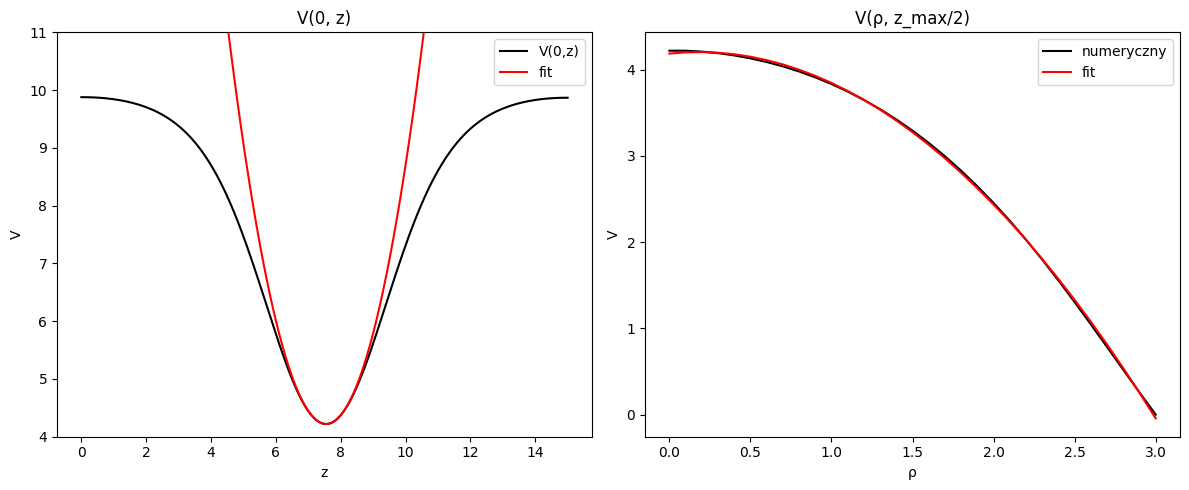

In [14]:
from numpy.polynomial import Polynomial

V_0z = trap.grid[0,:]


V_ro_z2 = trap.grid[:,int(trap.m/2)]


# Fit parabolas (2nd degree polynomials)
fit_z = Polynomial.fit(z[70:80], V_0z[70:80], 2)
fit_rho = Polynomial.fit(rho, V_ro_z2, 2)

# Evaluate fits
V_0z_fit = fit_z(z)
V_ro_z2_fit = fit_rho(rho)

# Plot V(0, z)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(z, V_0z, label='V(0,z)', color='black')
plt.plot(z, V_0z_fit, label='fit', color='red')
plt.xlabel('z')
plt.ylabel('V')
plt.title('V(0, z)')
plt.ylim(4,11)  
plt.legend()

# Plot V(ρ, z_max/2)
plt.subplot(1, 2, 2)
plt.plot(rho, V_ro_z2, label='numeryczny', color='black')
plt.plot(rho, V_ro_z2_fit, label='fit', color='red')
plt.xlabel('ρ')
plt.ylabel('V')
plt.title('V(ρ, z_max/2)')
plt.legend()


plt.tight_layout()
plt.show()
